In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

In [17]:
CSV_PATH = '/content/train.csv'
CSV_PATH_TEST = '/content/test.csv'
df = pd.read_csv(CSV_PATH)
print(df.shape)

#해당 데이터는 2번째 index부터 parameters

#X에서는 ID(Transaction001), SUBCLASS(target) 제거
#Y에서는 ID만 제거

encoder = LabelEncoder()
for c in df.columns:
  if c != 'ID' or c!='SUBCLASS':
    df[c] = encoder.fit_transform(df[c])

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values #.reshapes(-1,1)


encoder2 = LabelEncoder()
y = encoder2.fit_transform(y)

X_train, X_val, y_train, y_val  = train_test_split(X, y,
                                                  test_size = 0.3, random_state=156)
print(X_train.shape)
print(X_val.shape)

(6201, 4386)
(4340, 4384)
(1861, 4384)


In [31]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.inp = X
    self.outp = y
    print(self.inp.shape)
    print(self.outp.shape)
  def __len__(self):
    return len(self.inp)
  def __getitem__(self, idx):
    inp = torch.FloatTensor(self.inp[idx])
    outp = torch.FloatTensor([self.outp[idx]])
    return inp, outp

In [6]:
class CustomTestDataset(Dataset):
  def __init__(self, CSV_PATH):
    df = pd.read_csv(CSV_PATH)

    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    for c in df.columns:
      if  c != 'ID':
        df[c] = encoder.fit_transform(df[c])

    # test 데이터는 1번째 index부터 parameter
    self.inp = df.iloc[:, 1:].values
    print(self.inp.shape)
  def __len__(self):
    return len(self.inp)
  def __getitem__(self, idx):
    inp = torch.FloatTensor(self.inp[idx])
    return inp


In [32]:
training_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)

valid_dataset = CustomDataset(X_val, y_val)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_data = CustomTestDataset(CSV_PATH_TEST)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#valid_dataloader = DataLoader(valid_data, batch_size=32, drop_last=True) # Add drop_last=True to your DataLoader
#test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=True)

(4340, 4384)
(4340,)
(1861, 4384)
(1861,)
(2546, 4384)


In [33]:
len(valid_dataset)

1861

In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

Feature batch shape: torch.Size([32, 4384])
Labels batch shape: torch.Size([32, 1])


In [20]:
import torch
import torch.nn as nn

from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

num_train_data = 4340
model = nn.Sequential(
   nn.Linear(4384, num_train_data),
   nn.ReLU(),
   nn.Linear(num_train_data, num_train_data),
   nn.ReLU(),
   nn.Linear(num_train_data, 26)
)
model.to(device)

lr = 1e-5 #1e-3
optim = Adam(model.parameters(), lr=lr)

for epoch in range(20):
   for data, label in train_dataloader:
       optim.zero_grad()
       # 입력 데이터를 모델의 입력에 맞게 모양을 변환
       data = torch.reshape(data, (-1, 4384)).to(device)
       preds = model(data)

       label = label.squeeze().long().to(device)

       loss = nn.CrossEntropyLoss()(preds, label)
       loss.backward()
       optim.step()

   print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "gene_cancers.pth")

epoch1 loss:2.701864242553711
epoch2 loss:3.6556427478790283
epoch3 loss:3.563769578933716
epoch4 loss:3.578465700149536
epoch5 loss:2.750086545944214
epoch6 loss:3.193502902984619
epoch7 loss:2.636913537979126
epoch8 loss:2.6239166259765625
epoch9 loss:2.8512625694274902
epoch10 loss:2.6950185298919678
epoch11 loss:2.767198085784912
epoch12 loss:2.4645206928253174
epoch13 loss:2.504002094268799
epoch14 loss:2.530435085296631
epoch15 loss:2.056100368499756
epoch16 loss:3.125295877456665
epoch17 loss:2.804288148880005
epoch18 loss:2.9239566326141357
epoch19 loss:2.224226474761963
epoch20 loss:2.5484814643859863


In [39]:
# ❶ 모델 가중치 불러오기
model.load_state_dict(torch.load("gene_cancers.pth", map_location=device))

num_corr = 0 # 분류에 성공한 전체 개수

with torch.no_grad(): # ❷ 기울기를 계산하지 않음
   for data, label in valid_dataloader:
       data = torch.reshape(data, (-1, 4384)).to(device)

       output = model(data.to(device))
       preds = output.data.max(1)[1] # ❸ 모델의 예측값 계산
       # ❹ 올바르게 분류한 개수
       corr = preds.eq(label.to(device).data.flatten()).sum().item()
       preds = preds.squeeze().long().to(device)
       #print(preds)
       #print(label.to(device).data.flatten())

       num_corr += corr
       print(num_corr, corr)


   print(f"Accuracy:{num_corr/len(valid_dataset)}") # 분류 정확도를 출력합니다.

<ipython-input-39-0c03ec624283>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gene_cancers.pth", map_location=device))


8 8
18 10
24 6
29 5
35 6
41 6
46 5
54 8
60 6
66 6
69 3
79 10
83 4
92 9
99 7
106 7
113 7
117 4
123 6
133 10
138 5
146 8
156 10
162 6
166 4
174 8
183 9
188 5
191 3
199 8
205 6
213 8
221 8
225 4
234 9
243 9
250 7
255 5
265 10
269 4
275 6
279 4
285 6
295 10
300 5
309 9
314 5
318 4
324 6
332 8
335 3
345 10
352 7
358 6
362 4
370 8
379 9
387 8
389 2
Accuracy:0.20902740462117142


In [40]:
# ❶ 모델 가중치 불러오기
model.load_state_dict(torch.load("gene_cancers.pth", map_location=device))
with torch.no_grad(): # ❷ 기울기를 계산하지 않음
   for data in test_loader:
       data = torch.reshape(data, (-1, 4384)).to(device)
       output = model(data.to(device))
       preds = output.data.max(1)[1] # ❸ 모델의 예측값 계산
       print(preds)

<ipython-input-40-a89365ecb653>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gene_cancers.pth", map_location=device))


tensor([20, 20, 20, 20, 20, 25, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 14, 20],
       device='cuda:0')
tensor([14, 20, 20, 20, 20, 20, 20, 14, 20, 20, 20, 25, 20, 20, 20, 20, 20, 14,
        20, 20, 20, 20, 20, 14, 20, 20, 20, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([20, 20, 25, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20,  4, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 25, 20, 20, 14, 20, 20, 14, 20, 20],
       device='cuda:0')
tensor([20, 20, 20, 20, 20, 20, 14, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 14, 20, 20, 20, 20, 20, 20, 20],
       device='cuda:0')
tensor([20, 14, 20, 20, 20, 20, 20, 20, 20, 14, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 25, 20, 20, 20, 20, 20, 20, 14, 20, 20, 20, 25, 20],
       dev

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS + 1):
  for batch_idx, samples in enumerate(dataloader):
    #print(epoch)
    x_train, y_train = samples # Corrected line - samples already contains x_train and y_train
    #print(x_train.size(), y_train.size()) # Print statement for debugging - check the sizes of your tensors in each batch

In [ ]:
n

In [ ]:
bbb

In [ ]:
x = torch.empty(5,3)
x

tensor([[ 6.7262e-44,  0.0000e+00,  6.7262e-44],
        [ 0.0000e+00,  1.4714e+23,  3.1117e-41],
        [ 4.2039e-45,  0.0000e+00,  3.3631e-44],
        [ 0.0000e+00,  1.1210e-44,  0.0000e+00],
        [-2.6088e+38, -2.6088e+38,  1.3593e-43]])

Files already downloaded and verified
Files already downloaded and verified


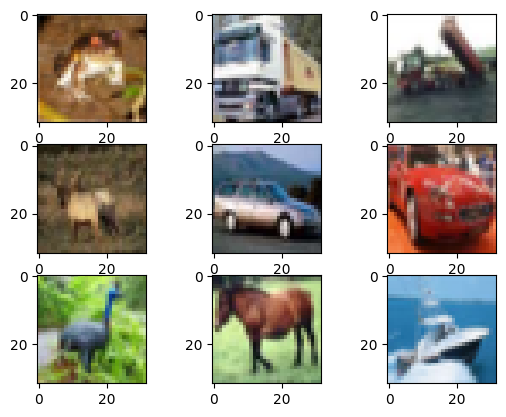

In [ ]:
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

# ❶ CIFAR10 데이터셋을 불러옴
training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=ToTensor())

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=ToTensor())

for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(training_data.data[i])
plt.show()

# 데이터 전처리에 크롭핑과 뒤집기를 추가

Files already downloaded and verified
Files already downloaded and verified


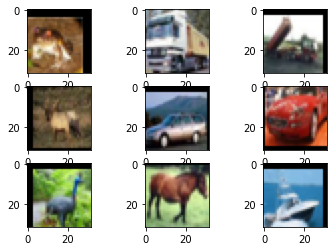

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([ # ❶ 데이터 전처리 함수들
   T.ToPILImage(),
   RandomCrop((32, 32), padding=4), # ➋ 랜덤으로 이미지 일부 제거 후 패딩
   RandomHorizontalFlip(p=0.5),     # ➌ y축으로 기준으로 대칭
])

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms) # transform에는 데이터를 변환하는 함수가 들어감

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms)

for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(transforms(training_data.data[i]))
plt.show()

# 데이터 전처리에 정규화를 추가

Files already downloaded and verified
Files already downloaded and verified


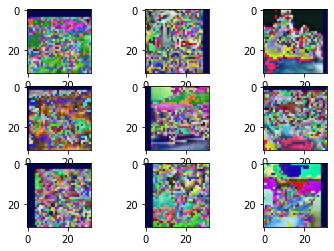

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

transforms = Compose([
   T.ToPILImage(),
   RandomCrop((32, 32), padding=4),
   RandomHorizontalFlip(p=0.5),
   T.ToTensor(),
   # ➊ 데이터 정규화
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
   T.ToPILImage()
])

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms)
test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms)

for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(transforms(training_data.data[i]))
plt.show()

# 데이터셋의 평균과 표준편차

In [ ]:
import torch

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=ToTensor())

# item[0]은 이미지, item[1]은 정답 레이블
imgs = [item[0] for item in training_data]

# ❶imgs를 하나로 합침
imgs = torch.stack(imgs, dim=0).numpy()

# rgb 각각의 평균
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

# rgb 각각의 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


# VGG 기본 블록 정의

In [ ]:
import torch
import torch.nn as nn


class BasicBlock(nn.Module): # ❶ 기본 블록을 정의합니다.
   # 기본블록을 구성하는 계층의 정의
   def __init__(self, in_channels, out_channels, hidden_dim):
       # ❷ nn.Module 클래스의 요소 상속
       super(BasicBlock, self).__init__()

       # ❸ 합성곱층 정의
       self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                              kernel_size=3, padding=1)
       self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                              kernel_size=3, padding=1)
       self.relu = nn.ReLU()

       # stride는 커널의 이동 거리를 의미합니다.
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

   def forward(self, x): # ➍  기본블록의 순전파 정의
       x = self.conv1(x)
       x = self.relu(x)
       x = self.conv2(x)
       x = self.relu(x)
       x = self.pool(x)

       return x

# VGG 모델 정의하기

In [ ]:
class CNN(nn.Module):
   def __init__(self, num_classes): # num_classes는 클래스의 개수를 의미합니다
       super(CNN, self).__init__()

       # ❶ 합성곱 기본 블록의 정의
       self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
       self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
       self.block3 = BasicBlock(in_channels=128, out_channels=256,
                                hidden_dim=128)

       # ❷ 분류기 정의
       self.fc1 = nn.Linear(in_features=4096, out_features=2048)
       self.fc2 = nn.Linear(in_features=2048, out_features=256)
       self.fc3 = nn.Linear(in_features=256, out_features=num_classes)


       # ❸ 분류기의 활성화 함수
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.block1(x)
       x = self.block2(x)
       x = self.block3(x)  # 출력 모양: (-1, 256, 4, 4)
       x = torch.flatten(x, start_dim=1) # ➍ 2차원 특징맵을 1차원으로

       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)

       return x

# 데이터 증강 정의

In [ ]:
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

transforms = Compose([
   RandomCrop((32, 32), padding=4),  # ❶ 랜덤 크롭핑
   RandomHorizontalFlip(p=0.5),  # ❷ y축으로 뒤집기
   ToTensor(),  # ❸ 텐서로 변환
   # ❹ 이미지 정규화
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

# 데이터 로드 및 모델 정의

In [ ]:
# ❶ 학습 데이터와 평가 데이터 불러오기
training_data = CIFAR10(root="./", train=True, download=True, transform=transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=transforms)


# ❷ 데이터로더 정의
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# ❸ 학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"


# ➍ CNN 모델 정의
model = CNN(num_classes=10)

# ➎ 모델을 device로 보냄
model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

# 모델 학습하기

In [ ]:
# ❶ 학습률 정의
lr = 1e-3

# ❷ 최적화 기법 정의
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(100):
   for data, label in train_loader:  # ➌ 데이터 호출
       optim.zero_grad()  # ➍ 기울기 초기화

       preds = model(data.to(device))  # ➎ 모델의 예측

       # ➏ 오차역전파와 최적화
       loss = nn.CrossEntropyLoss()(preds, label.to(device))
       loss.backward()
       optim.step()

   if epoch==0 or epoch%10==9:  # 10번마다 손실 출력
       print(f"epoch{epoch+1} loss:{loss.item()}")


# 모델 저장
torch.save(model.state_dict(), "CIFAR.pth")

epoch1 loss:1.345447063446045
epoch10 loss:0.6160560250282288
epoch20 loss:0.3506152629852295
epoch30 loss:0.3585073947906494
epoch40 loss:0.10344330221414566
epoch50 loss:0.6372717618942261
epoch60 loss:0.059298984706401825
epoch70 loss:0.2963455319404602
epoch80 loss:0.5042433738708496
epoch90 loss:0.005110104102641344
epoch100 loss:0.43459805846214294


In [ ]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")

Accuracy:0.8205
